In [1]:
# Cell 1: Imports and Setup
import json
import re
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Paths
BASE_DIR = Path('outputs')
RESULTS_DIR = BASE_DIR / 'results'
E2E_DIR = BASE_DIR / 'prod_e2e'
WHISPER_DIR = BASE_DIR / 'prod_whisper'

print(f"Base directory: {BASE_DIR.resolve()}")
print(f"Results exist: {RESULTS_DIR.exists()}")

Base directory: C:\Users\Quang Chien\main_source\final_nlp\training\outputs
Results exist: True


In [2]:
# Cell 2: Load All Data

def load_json(path: Path) -> Dict:
    """Load a JSON file and return its contents."""
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

def parse_log_file(log_path: Path) -> Dict[str, Any]:
    """Parse training log file to extract training metrics."""
    steps, losses, lrs = [], [], []
    epochs = []
    config_lines = []
    in_config = False
    
    with open(log_path, 'r', encoding='utf-8') as f:
        for line in f:
            # Extract step info
            step_match = re.search(r'Step (\d+) \| Loss: ([\d.]+) \| LR: ([\d.e+-]+)', line)
            if step_match:
                steps.append(int(step_match.group(1)))
                losses.append(float(step_match.group(2)))
                lrs.append(float(step_match.group(3)))
            
            # Extract epoch info
            epoch_match = re.search(r'Epoch (\d+)/(\d+) started', line)
            if epoch_match:
                epochs.append({'epoch': int(epoch_match.group(1)), 'step': steps[-1] if steps else 0})
            
            # Extract config
            if 'Configuration:' in line:
                in_config = True
            elif in_config and ('====' in line or 'Loading' in line):
                in_config = False
            elif in_config:
                config_lines.append(line.strip())
    
    return {
        'steps': steps,
        'losses': losses,
        'lrs': lrs,
        'epochs': epochs,
        'config_text': '\n'.join(config_lines)
    }

# Load metrics
e2e_metrics = load_json(RESULTS_DIR / 'prod_e2e_metrics.json')
whisper_metrics = load_json(RESULTS_DIR / 'prod_whisper_metrics.json')

# Load train results
e2e_train_results = load_json(E2E_DIR / 'train_results.json')
whisper_train_results = load_json(WHISPER_DIR / 'train_results.json')

# Load predictions
e2e_predictions = pd.read_csv(RESULTS_DIR / 'prod_e2e_predictions.csv')
whisper_predictions = pd.read_csv(RESULTS_DIR / 'prod_whisper_predictions.csv')

# Parse logs
e2e_log_path = list((E2E_DIR / 'logs').glob('*.log'))[0]
whisper_log_path = list((WHISPER_DIR / 'logs').glob('*.log'))[0]

e2e_log_data = parse_log_file(e2e_log_path)
whisper_log_data = parse_log_file(whisper_log_path)

print(f"E2E samples: {len(e2e_predictions)}, Whisper samples: {len(whisper_predictions)}")
print(f"E2E steps logged: {len(e2e_log_data['steps'])}, Whisper steps: {len(whisper_log_data['steps'])}")

E2E samples: 1496, Whisper samples: 1496
E2E steps logged: 175, Whisper steps: 175


---
## Section 1: Training Configuration Comparison

In [3]:
# Cell 3: Training Configuration Table

def extract_config_value(config_text: str, key: str) -> str:
    """Extract a configuration value from the parsed config text."""
    for line in config_text.split('\n'):
        if key in line:
            parts = line.split(':')
            if len(parts) >= 2:
                return parts[-1].strip()
    return 'N/A'

config_keys = [
    'batch_size', 'gradient_accumulation_steps', 'learning_rate',
    'lr_scheduler_type', 'warmup_ratio', 'weight_decay',
    'num_train_epochs', 'bf16'
]

config_comparison = []
for key in config_keys:
    config_comparison.append({
        'Parameter': key,
        'E2E Model': extract_config_value(e2e_log_data['config_text'], key),
        'Whisper Model': extract_config_value(whisper_log_data['config_text'], key)
    })

# Add model-specific info
config_comparison.extend([
    {'Parameter': 'Encoder', 'E2E Model': 'facebook/wav2vec2-base', 'Whisper Model': 'openai/whisper-small'},
    {'Parameter': 'Decoder', 'E2E Model': 'facebook/mbart-large-50', 'Whisper Model': '(built-in)'},
    {'Parameter': 'Effective Batch Size', 
     'E2E Model': f"{2 * 16} = 32", 
     'Whisper Model': f"{32 * 1} = 32"}
])

config_df = pd.DataFrame(config_comparison)
print("="*60)
print("TRAINING CONFIGURATION COMPARISON")
print("="*60)
display(config_df.style.set_properties(**{'text-align': 'left'}).hide(axis='index'))

TRAINING CONFIGURATION COMPARISON


Parameter,E2E Model,Whisper Model
batch_size,2,32
gradient_accumulation_steps,16,1
learning_rate,1e-05,2e-05
lr_scheduler_type,linear,linear
warmup_ratio,0.05,0.05
weight_decay,0.01,0.01
num_train_epochs,4,4
bf16,True,True
Encoder,facebook/wav2vec2-base,openai/whisper-small
Decoder,facebook/mbart-large-50,(built-in)


---
## Section 2: Training Loss & Learning Rate Curves

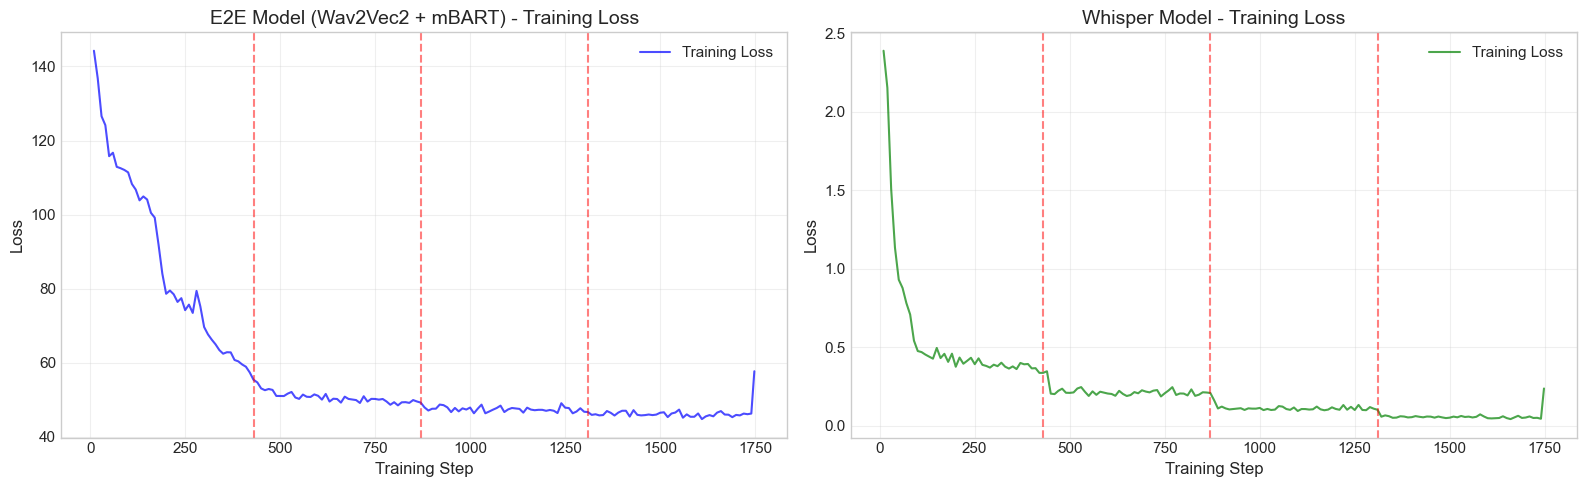

E2E: Initial Loss = 144.23, Final Loss = 57.70
Whisper: Initial Loss = 2.39, Final Loss = 0.24


In [4]:
# Cell 4: Training Loss Curves

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# E2E Loss
ax1 = axes[0]
ax1.plot(e2e_log_data['steps'], e2e_log_data['losses'], 'b-', linewidth=1.5, alpha=0.7, label='Training Loss')
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss')
ax1.set_title('E2E Model (Wav2Vec2 + mBART) - Training Loss')

# Add epoch markers
for epoch_info in e2e_log_data['epochs'][1:]:  # Skip first
    ax1.axvline(x=epoch_info['step'], color='red', linestyle='--', alpha=0.5)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Whisper Loss
ax2 = axes[1]
ax2.plot(whisper_log_data['steps'], whisper_log_data['losses'], 'g-', linewidth=1.5, alpha=0.7, label='Training Loss')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Loss')
ax2.set_title('Whisper Model - Training Loss')

for epoch_info in whisper_log_data['epochs'][1:]:
    ax2.axvline(x=epoch_info['step'], color='red', linestyle='--', alpha=0.5)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/training_loss_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"E2E: Initial Loss = {e2e_log_data['losses'][0]:.2f}, Final Loss = {e2e_log_data['losses'][-1]:.2f}")
print(f"Whisper: Initial Loss = {whisper_log_data['losses'][0]:.2f}, Final Loss = {whisper_log_data['losses'][-1]:.2f}")

C:\Users\Quang Chien\AppData\Local\Temp\ipykernel_7068\2857409901.py:17: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Quang Chien\AppData\Local\Temp\ipykernel_7068\2857409901.py:18: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.savefig('outputs/learning_rate_curves.png', dpi=150, bbox_inches='tight')
c:\Users\Quang Chien\main_source\final_nlp\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


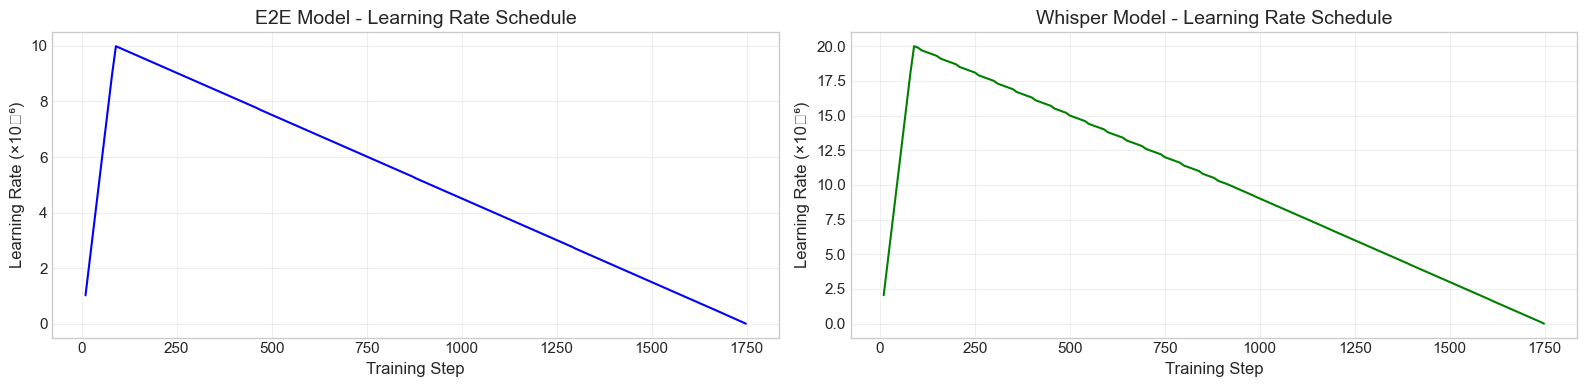

In [5]:
# Cell 5: Learning Rate Schedules

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(e2e_log_data['steps'], [lr * 1e6 for lr in e2e_log_data['lrs']], 'b-', linewidth=1.5)
axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Learning Rate (×10⁻⁶)')
axes[0].set_title('E2E Model - Learning Rate Schedule')
axes[0].grid(True, alpha=0.3)

axes[1].plot(whisper_log_data['steps'], [lr * 1e6 for lr in whisper_log_data['lrs']], 'g-', linewidth=1.5)
axes[1].set_xlabel('Training Step')
axes[1].set_ylabel('Learning Rate (×10⁻⁶)')
axes[1].set_title('Whisper Model - Learning Rate Schedule')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/learning_rate_curves.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 3: Epoch-wise Loss Analysis

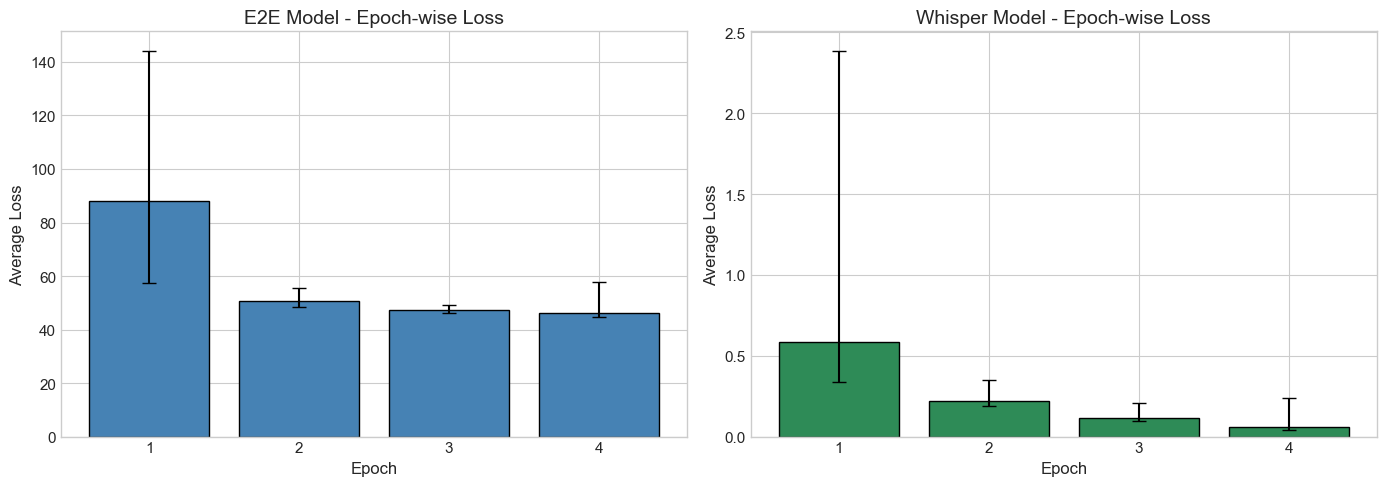


E2E Epoch Summary:


,Epoch,Avg Loss,Min Loss,Max Loss
0,1,88.137731,57.3852,144.2344
1,2,50.682825,48.4903,55.3961
2,3,47.474470,46.3472,49.2281
3,4,46.349887,44.7847,57.7030



Whisper Epoch Summary:


,Epoch,Avg Loss,Min Loss,Max Loss
0,1,0.582900,0.3376,2.3872
1,2,0.218232,0.1877,0.3479
2,3,0.113657,0.0951,0.2097
3,4,0.061193,0.0436,0.2383


In [6]:
# Cell 6: Epoch-wise Loss Analysis

def compute_epoch_losses(log_data: Dict) -> pd.DataFrame:
    """Compute average loss per epoch."""
    epochs_info = log_data['epochs']
    steps = log_data['steps']
    losses = log_data['losses']
    
    epoch_losses = []
    for i, epoch_info in enumerate(epochs_info):
        start_step = epoch_info['step']
        end_step = epochs_info[i + 1]['step'] if i + 1 < len(epochs_info) else steps[-1] + 1
        
        epoch_mask = [(s >= start_step and s < end_step) for s in steps]
        epoch_loss_vals = [l for l, m in zip(losses, epoch_mask) if m]
        
        if epoch_loss_vals:
            epoch_losses.append({
                'Epoch': epoch_info['epoch'],
                'Avg Loss': np.mean(epoch_loss_vals),
                'Min Loss': np.min(epoch_loss_vals),
                'Max Loss': np.max(epoch_loss_vals)
            })
    
    return pd.DataFrame(epoch_losses)

e2e_epoch_df = compute_epoch_losses(e2e_log_data)
whisper_epoch_df = compute_epoch_losses(whisper_log_data)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# E2E
ax = axes[0]
bars = ax.bar(e2e_epoch_df['Epoch'], e2e_epoch_df['Avg Loss'], color='steelblue', edgecolor='black')
ax.errorbar(e2e_epoch_df['Epoch'], e2e_epoch_df['Avg Loss'], 
            yerr=[e2e_epoch_df['Avg Loss'] - e2e_epoch_df['Min Loss'],
                  e2e_epoch_df['Max Loss'] - e2e_epoch_df['Avg Loss']],
            fmt='none', color='black', capsize=5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Loss')
ax.set_title('E2E Model - Epoch-wise Loss')
ax.set_xticks(e2e_epoch_df['Epoch'])

# Whisper
ax = axes[1]
bars = ax.bar(whisper_epoch_df['Epoch'], whisper_epoch_df['Avg Loss'], color='seagreen', edgecolor='black')
ax.errorbar(whisper_epoch_df['Epoch'], whisper_epoch_df['Avg Loss'],
            yerr=[whisper_epoch_df['Avg Loss'] - whisper_epoch_df['Min Loss'],
                  whisper_epoch_df['Max Loss'] - whisper_epoch_df['Avg Loss']],
            fmt='none', color='black', capsize=5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Loss')
ax.set_title('Whisper Model - Epoch-wise Loss')
ax.set_xticks(whisper_epoch_df['Epoch'])

plt.tight_layout()
plt.savefig('outputs/epoch_loss_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nE2E Epoch Summary:")
display(e2e_epoch_df)
print("\nWhisper Epoch Summary:")
display(whisper_epoch_df)

---
## Section 4: Final ASR Metrics Comparison

ASR PERFORMANCE METRICS


Metric,E2E Model,Whisper Model
WER (%),97.51,399.78
CER (%),75.54,374.59
Avg Latency (ms),45.69,115.12


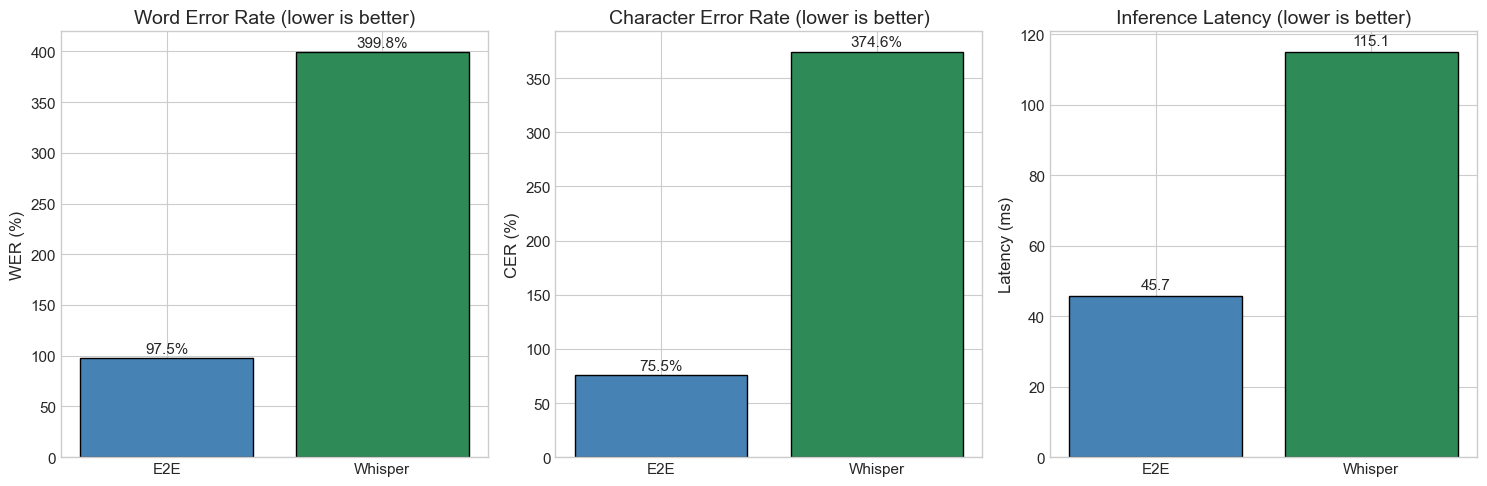

In [7]:
# Cell 7: ASR Metrics (WER, CER)

# Create comparison DataFrame
metrics_comparison = pd.DataFrame({
    'Metric': ['WER (%)', 'CER (%)', 'Avg Latency (ms)'],
    'E2E Model': [e2e_metrics['wer'], e2e_metrics['cer'], e2e_metrics['avg_latency_ms']],
    'Whisper Model': [whisper_metrics['wer'], whisper_metrics['cer'], whisper_metrics['avg_latency_ms']]
})

print("="*60)
print("ASR PERFORMANCE METRICS")
print("="*60)
display(metrics_comparison.style.format({'E2E Model': '{:.2f}', 'Whisper Model': '{:.2f}'}).hide(axis='index'))

# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# WER
ax = axes[0]
models = ['E2E', 'Whisper']
wer_vals = [e2e_metrics['wer'], whisper_metrics['wer']]
colors = ['steelblue', 'seagreen']
bars = ax.bar(models, wer_vals, color=colors, edgecolor='black')
ax.set_ylabel('WER (%)')
ax.set_title('Word Error Rate (lower is better)')
for bar, val in zip(bars, wer_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{val:.1f}%', ha='center', fontsize=11)

# CER
ax = axes[1]
cer_vals = [e2e_metrics['cer'], whisper_metrics['cer']]
bars = ax.bar(models, cer_vals, color=colors, edgecolor='black')
ax.set_ylabel('CER (%)')
ax.set_title('Character Error Rate (lower is better)')
for bar, val in zip(bars, cer_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{val:.1f}%', ha='center', fontsize=11)

# Latency
ax = axes[2]
lat_vals = [e2e_metrics['avg_latency_ms'], whisper_metrics['avg_latency_ms']]
bars = ax.bar(models, lat_vals, color=colors, edgecolor='black')
ax.set_ylabel('Latency (ms)')
ax.set_title('Inference Latency (lower is better)')
for bar, val in zip(bars, lat_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.1f}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig('outputs/asr_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 5: Translation Metrics (E2E Only)

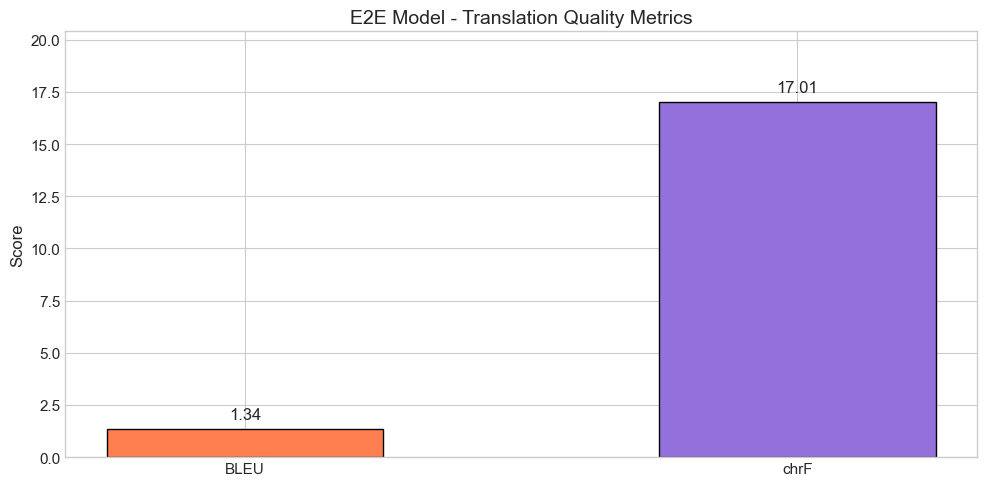


E2E Translation Metrics:
  BLEU Score: 1.34
  chrF Score: 17.01


In [8]:
# Cell 8: Translation Metrics

fig, ax = plt.subplots(figsize=(10, 5))

trans_metrics = ['BLEU', 'chrF']
trans_vals = [e2e_metrics.get('bleu', 0), e2e_metrics.get('chrf', 0)]

bars = ax.bar(trans_metrics, trans_vals, color=['coral', 'mediumpurple'], edgecolor='black', width=0.5)
ax.set_ylabel('Score')
ax.set_title('E2E Model - Translation Quality Metrics')

for bar, val in zip(bars, trans_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.2f}', ha='center', fontsize=12)

ax.set_ylim(0, max(trans_vals) * 1.2)
plt.tight_layout()
plt.savefig('outputs/translation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nE2E Translation Metrics:")
print(f"  BLEU Score: {e2e_metrics.get('bleu', 0):.2f}")
print(f"  chrF Score: {e2e_metrics.get('chrf', 0):.2f}")

---
## Section 6: Per-Sample Error Analysis

In [9]:
# Cell 9: Per-Sample WER/CER Calculation

def calculate_wer(reference: str, hypothesis: str) -> float:
    """Calculate Word Error Rate between reference and hypothesis."""
    if pd.isna(reference) or pd.isna(hypothesis):
        return np.nan
    
    ref_words = str(reference).split()
    hyp_words = str(hypothesis).split()
    
    if len(ref_words) == 0:
        return 100.0 if len(hyp_words) > 0 else 0.0
    
    # Simple edit distance for WER
    d = np.zeros((len(ref_words) + 1, len(hyp_words) + 1))
    
    for i in range(len(ref_words) + 1):
        d[i][0] = i
    for j in range(len(hyp_words) + 1):
        d[0][j] = j
    
    for i in range(1, len(ref_words) + 1):
        for j in range(1, len(hyp_words) + 1):
            if ref_words[i-1] == hyp_words[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                d[i][j] = min(d[i-1][j] + 1,      # deletion
                              d[i][j-1] + 1,      # insertion
                              d[i-1][j-1] + 1)    # substitution
    
    return (d[len(ref_words)][len(hyp_words)] / len(ref_words)) * 100

def calculate_cer(reference: str, hypothesis: str) -> float:
    """Calculate Character Error Rate between reference and hypothesis."""
    if pd.isna(reference) or pd.isna(hypothesis):
        return np.nan
    
    ref_chars = list(str(reference))
    hyp_chars = list(str(hypothesis))
    
    if len(ref_chars) == 0:
        return 100.0 if len(hyp_chars) > 0 else 0.0
    
    d = np.zeros((len(ref_chars) + 1, len(hyp_chars) + 1))
    
    for i in range(len(ref_chars) + 1):
        d[i][0] = i
    for j in range(len(hyp_chars) + 1):
        d[0][j] = j
    
    for i in range(1, len(ref_chars) + 1):
        for j in range(1, len(hyp_chars) + 1):
            if ref_chars[i-1] == hyp_chars[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                d[i][j] = min(d[i-1][j] + 1,
                              d[i][j-1] + 1,
                              d[i-1][j-1] + 1)
    
    return (d[len(ref_chars)][len(hyp_chars)] / len(ref_chars)) * 100

print("Calculating per-sample WER and CER...")

# E2E
e2e_predictions['wer'] = e2e_predictions.apply(
    lambda row: calculate_wer(row['asr_reference'], row['asr_prediction']), axis=1)
e2e_predictions['cer'] = e2e_predictions.apply(
    lambda row: calculate_cer(row['asr_reference'], row['asr_prediction']), axis=1)

# Whisper
whisper_predictions['wer'] = whisper_predictions.apply(
    lambda row: calculate_wer(row['asr_reference'], row['asr_prediction']), axis=1)
whisper_predictions['cer'] = whisper_predictions.apply(
    lambda row: calculate_cer(row['asr_reference'], row['asr_prediction']), axis=1)

print(f"E2E - Mean WER: {e2e_predictions['wer'].mean():.2f}%, Mean CER: {e2e_predictions['cer'].mean():.2f}%")
print(f"Whisper - Mean WER: {whisper_predictions['wer'].mean():.2f}%, Mean CER: {whisper_predictions['cer'].mean():.2f}%")

Calculating per-sample WER and CER...
E2E - Mean WER: 102.86%, Mean CER: 80.12%
Whisper - Mean WER: 871.98%, Mean CER: 911.44%


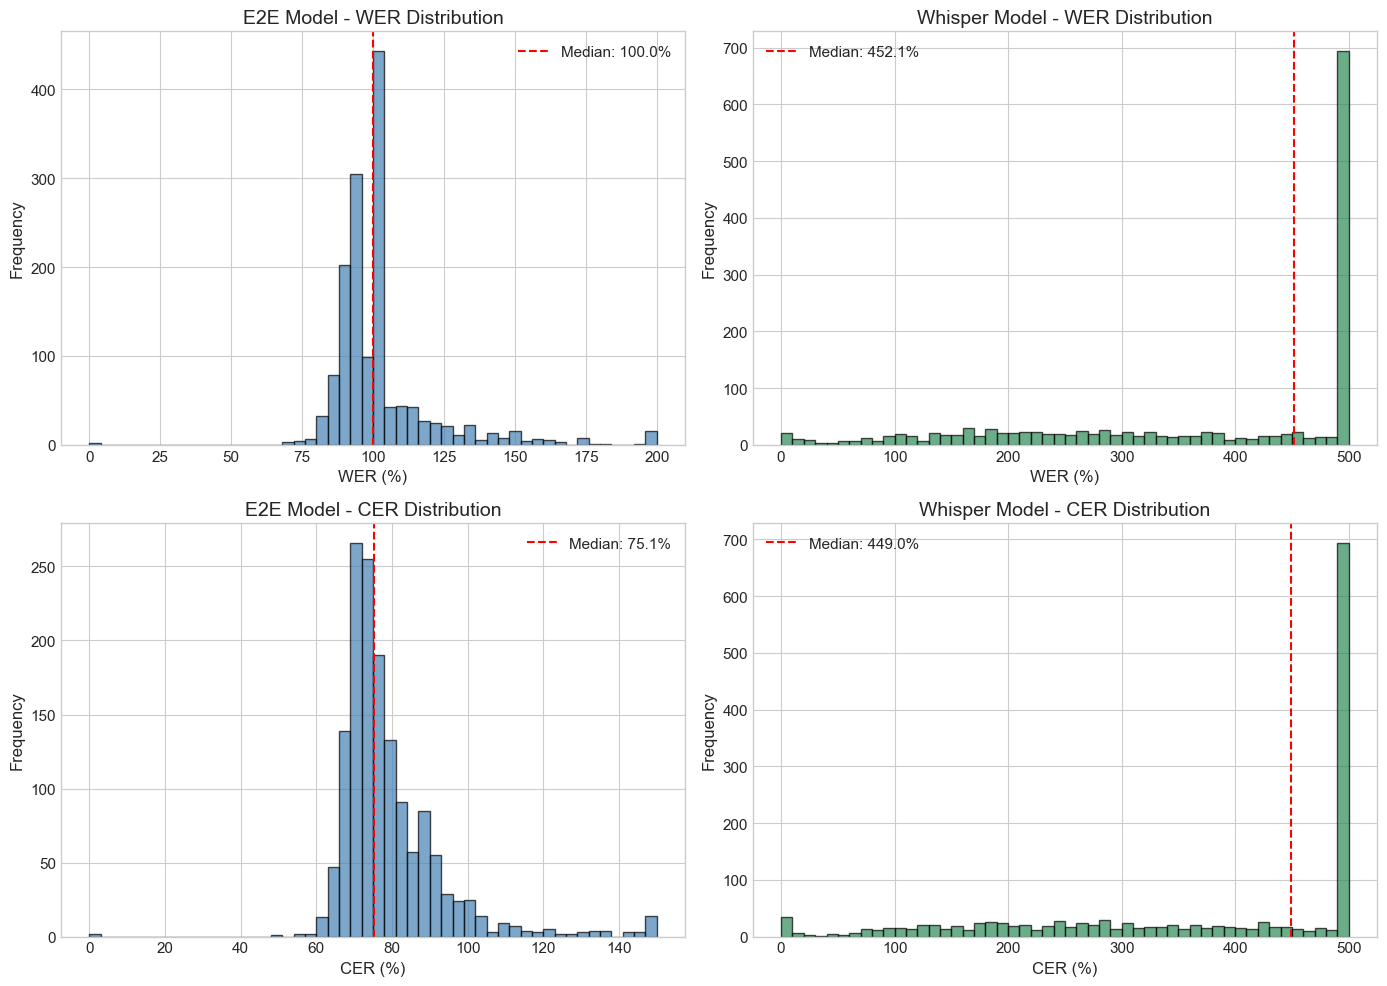

In [10]:
# Cell 10: Error Distribution Histograms

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# E2E WER distribution
ax = axes[0, 0]
e2e_wer_clipped = e2e_predictions['wer'].clip(upper=200)
ax.hist(e2e_wer_clipped.dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(e2e_predictions['wer'].median(), color='red', linestyle='--', label=f"Median: {e2e_predictions['wer'].median():.1f}%")
ax.set_xlabel('WER (%)')
ax.set_ylabel('Frequency')
ax.set_title('E2E Model - WER Distribution')
ax.legend()

# Whisper WER distribution
ax = axes[0, 1]
whisper_wer_clipped = whisper_predictions['wer'].clip(upper=500)
ax.hist(whisper_wer_clipped.dropna(), bins=50, color='seagreen', edgecolor='black', alpha=0.7)
ax.axvline(whisper_predictions['wer'].median(), color='red', linestyle='--', label=f"Median: {whisper_predictions['wer'].median():.1f}%")
ax.set_xlabel('WER (%)')
ax.set_ylabel('Frequency')
ax.set_title('Whisper Model - WER Distribution')
ax.legend()

# E2E CER distribution
ax = axes[1, 0]
e2e_cer_clipped = e2e_predictions['cer'].clip(upper=150)
ax.hist(e2e_cer_clipped.dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(e2e_predictions['cer'].median(), color='red', linestyle='--', label=f"Median: {e2e_predictions['cer'].median():.1f}%")
ax.set_xlabel('CER (%)')
ax.set_ylabel('Frequency')
ax.set_title('E2E Model - CER Distribution')
ax.legend()

# Whisper CER distribution
ax = axes[1, 1]
whisper_cer_clipped = whisper_predictions['cer'].clip(upper=500)
ax.hist(whisper_cer_clipped.dropna(), bins=50, color='seagreen', edgecolor='black', alpha=0.7)
ax.axvline(whisper_predictions['cer'].median(), color='red', linestyle='--', label=f"Median: {whisper_predictions['cer'].median():.1f}%")
ax.set_xlabel('CER (%)')
ax.set_ylabel('Frequency')
ax.set_title('Whisper Model - CER Distribution')
ax.legend()

plt.tight_layout()
plt.savefig('outputs/error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Section 7: Prediction Length Analysis

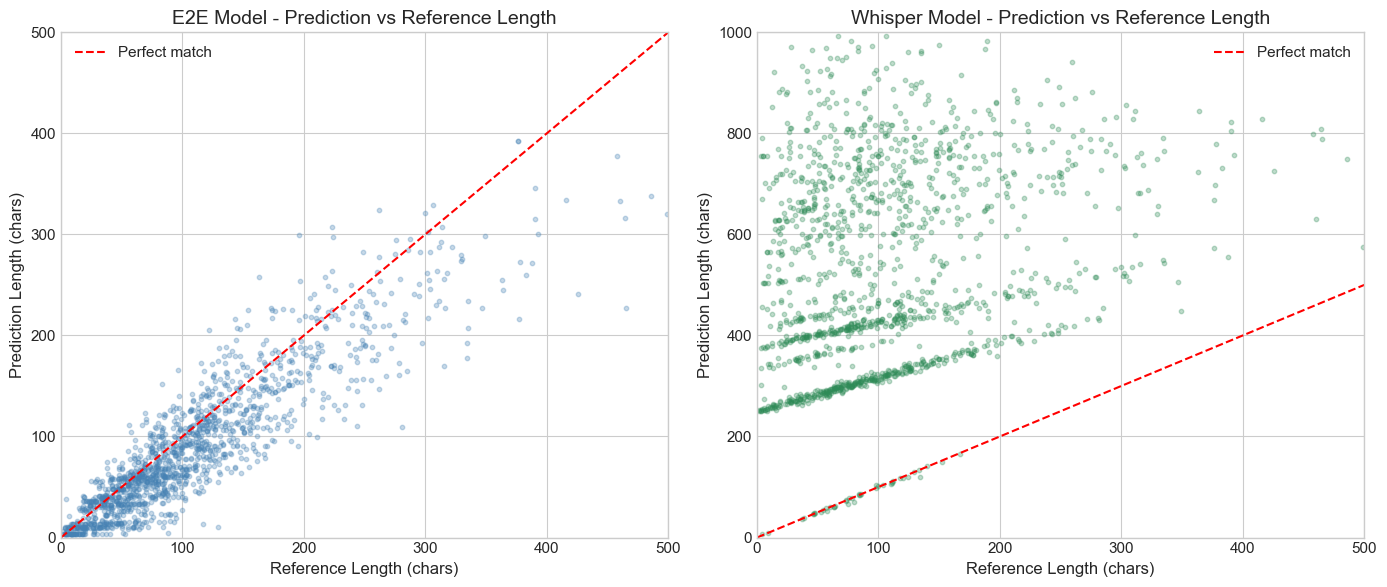


E2E Length Ratio Stats:
  Mean: 0.85, Median: 0.83

Whisper Length Ratio Stats:
  Mean: 10.00, Median: 5.38

Note: Whisper appears to have severe repetition issues (ratio >> 1)


In [11]:
# Cell 11: Prediction vs Reference Length

# Calculate lengths
e2e_predictions['ref_len'] = e2e_predictions['asr_reference'].fillna('').apply(len)
e2e_predictions['pred_len'] = e2e_predictions['asr_prediction'].fillna('').apply(len)
e2e_predictions['len_ratio'] = e2e_predictions['pred_len'] / e2e_predictions['ref_len'].replace(0, np.nan)

whisper_predictions['ref_len'] = whisper_predictions['asr_reference'].fillna('').apply(len)
whisper_predictions['pred_len'] = whisper_predictions['asr_prediction'].fillna('').apply(len)
whisper_predictions['len_ratio'] = whisper_predictions['pred_len'] / whisper_predictions['ref_len'].replace(0, np.nan)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# E2E
ax = axes[0]
ax.scatter(e2e_predictions['ref_len'], e2e_predictions['pred_len'], alpha=0.3, s=10, c='steelblue')
max_len = max(e2e_predictions['ref_len'].max(), e2e_predictions['pred_len'].max())
ax.plot([0, max_len], [0, max_len], 'r--', label='Perfect match')
ax.set_xlabel('Reference Length (chars)')
ax.set_ylabel('Prediction Length (chars)')
ax.set_title('E2E Model - Prediction vs Reference Length')
ax.legend()
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)

# Whisper
ax = axes[1]
ax.scatter(whisper_predictions['ref_len'], whisper_predictions['pred_len'], alpha=0.3, s=10, c='seagreen')
max_len = 1000
ax.plot([0, max_len], [0, max_len], 'r--', label='Perfect match')
ax.set_xlabel('Reference Length (chars)')
ax.set_ylabel('Prediction Length (chars)')
ax.set_title('Whisper Model - Prediction vs Reference Length')
ax.legend()
ax.set_xlim(0, 500)
ax.set_ylim(0, 1000)

plt.tight_layout()
plt.savefig('outputs/length_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nE2E Length Ratio Stats:")
print(f"  Mean: {e2e_predictions['len_ratio'].mean():.2f}, Median: {e2e_predictions['len_ratio'].median():.2f}")
print(f"\nWhisper Length Ratio Stats:")
print(f"  Mean: {whisper_predictions['len_ratio'].mean():.2f}, Median: {whisper_predictions['len_ratio'].median():.2f}")
print(f"\nNote: Whisper appears to have severe repetition issues (ratio >> 1)")

---
## Section 8: Sample Difficulty Ranking

In [12]:
# Cell 12: Hardest and Easiest Samples

# Top 10 hardest samples (highest WER)
print("="*80)
print("E2E MODEL - TOP 10 HARDEST SAMPLES (Highest WER)")
print("="*80)

e2e_hardest = e2e_predictions.nlargest(10, 'wer')[['id', 'wer', 'cer', 'asr_reference', 'asr_prediction']]
for idx, row in e2e_hardest.iterrows():
    print(f"\nSample {row['id']} | WER: {row['wer']:.1f}% | CER: {row['cer']:.1f}%")
    print(f"  REF: {str(row['asr_reference'])[:100]}...")
    print(f"  PRED: {str(row['asr_prediction'])[:100]}...")

E2E MODEL - TOP 10 HARDEST SAMPLES (Highest WER)

Sample 1217 | WER: 1000.0% | CER: 950.0%
  REF: 2571...
  PRED: Em có thể chia sẻ với anh ấy một chút....

Sample 994 | WER: 400.0% | CER: 142.9%
  REF: Okay, recommendation....
  PRED: I'm gonna be a little bit like that....

Sample 488 | WER: 300.0% | CER: 266.7%
  REF: Hứ....
  PRED: Ừm. Ừ. Ờ....

Sample 502 | WER: 300.0% | CER: 271.4%
  REF: Thế thì...
  PRED: I'm not a fan of you....

Sample 469 | WER: 260.0% | CER: 176.0%
  REF: Điều này đúng đúng không?...
  PRED: Ừm. Ừ. Ờ. Cũng không biết là có phải là mình không biết....

Sample 427 | WER: 200.0% | CER: 137.5%
  REF: Cũng có....
  PRED: Ừm. Ừ. Ờ. ừm....

Sample 485 | WER: 200.0% | CER: 157.9%
  REF: Em chắc chắn là có....
  PRED: Ừm. Ừ. Ờ. Cũng có thể là một cái gì đấy....

Sample 512 | WER: 200.0% | CER: 250.0%
  REF: Ờ....
  PRED: Ừm. Ừ....

Sample 563 | WER: 200.0% | CER: 133.3%
  REF: Vivuu....
  PRED: I'm proud....

Sample 687 | WER: 200.0% | CER: 200.0%
  REF: Ừm....
  PR

In [13]:
# Cell 13: Best Samples

# Top 10 best samples (lowest WER, excluding zero-length)
print("="*80)
print("E2E MODEL - TOP 10 BEST SAMPLES (Lowest WER)")
print("="*80)

e2e_valid = e2e_predictions[e2e_predictions['ref_len'] > 10]  # Filter out very short refs
e2e_best = e2e_valid.nsmallest(10, 'wer')[['id', 'wer', 'cer', 'asr_reference', 'asr_prediction']]
for idx, row in e2e_best.iterrows():
    print(f"\nSample {row['id']} | WER: {row['wer']:.1f}% | CER: {row['cer']:.1f}%")
    print(f"  REF: {str(row['asr_reference'])[:100]}")
    print(f"  PRED: {str(row['asr_prediction'])[:100]}")

E2E MODEL - TOP 10 BEST SAMPLES (Lowest WER)

Sample 213 | WER: 69.2% | CER: 51.0%
  REF: Nhưng mà kiểu là mình lúc đó còn nhỏ mà rất là máu.
  PRED: Nhưng mà nó vẫn là một cái gì đấy rất là khác.

Sample 864 | WER: 70.0% | CER: 59.5%
  REF: Em có là người giỏi bày tỏ tình cảm không?
  PRED: Em có thể là em có thể làm được không?

Sample 230 | WER: 71.4% | CER: 64.2%
  REF: Em nghĩ là em sẽ lập một kế hoạch như thế nào với mẹ?
  PRED: Em nghĩ là em sẽ không bao giờ em sẽ nói về cái chuyện đấy.

Sample 441 | WER: 75.0% | CER: 69.2%
  REF: Em cần có họ.
  PRED: Em không biết.

Sample 553 | WER: 75.0% | CER: 69.2%
  REF: Em cần có họ.
  PRED: Em không biết.

Sample 712 | WER: 75.0% | CER: 55.2%
  REF: qua những cái thời điểm mình không có thể mà lúc nào nó mình cũng đứng một vị trí được.
  PRED: Nhưng mà mình cũng không thể nào mà mình không thể làm được.

Sample 663 | WER: 75.9% | CER: 67.0%
  REF: Nhưng mà đối với em thì cái trách nhiệm nó vẫn là quan trọng. Khi mình nhận một cái điều g

---
## Section 9: Training Efficiency Metrics

In [14]:
# Cell 14: Training Efficiency

efficiency_data = pd.DataFrame({
    'Metric': [
        'Final Training Loss',
        'Training Runtime (seconds)',
        'Training Runtime (hours)',
        'Samples per Second',
        'Total Steps',
        'Loss Reduction (Initial → Final)'
    ],
    'E2E Model': [
        f"{e2e_train_results['train_loss']:.4f}",
        f"{e2e_train_results['train_runtime']:.1f}",
        f"{e2e_train_results['train_runtime']/3600:.2f}",
        f"{e2e_train_results['train_samples_per_second']:.2f}",
        f"{len(e2e_log_data['steps'])}",
        f"{e2e_log_data['losses'][0]:.1f} → {e2e_log_data['losses'][-1]:.1f}"
    ],
    'Whisper Model': [
        f"{whisper_train_results['train_loss']:.4f}",
        f"{whisper_train_results['train_runtime']:.1f}",
        f"{whisper_train_results['train_runtime']/3600:.2f}",
        f"{whisper_train_results['train_samples_per_second']:.2f}",
        f"{len(whisper_log_data['steps'])}",
        f"{whisper_log_data['losses'][0]:.2f} → {whisper_log_data['losses'][-1]:.2f}"
    ]
})

print("="*60)
print("TRAINING EFFICIENCY COMPARISON")
print("="*60)
display(efficiency_data.style.hide(axis='index'))

TRAINING EFFICIENCY COMPARISON


Metric,E2E Model,Whisper Model
Final Training Loss,57.7030,0.2383
Training Runtime (seconds),1932.3,414.8
Training Runtime (hours),0.54,0.12
Samples per Second,28.95,134.86
Total Steps,175,175
Loss Reduction (Initial → Final),144.2 → 57.7,2.39 → 0.24


---
## Section 10: Sample Predictions Display

In [15]:
# Cell 15: Random Sample Predictions

np.random.seed(42)
sample_indices = np.random.choice(len(e2e_predictions), 5, replace=False)

print("="*80)
print("RANDOM SAMPLE PREDICTIONS - E2E MODEL")
print("="*80)

for idx in sample_indices:
    row = e2e_predictions.iloc[idx]
    print(f"\n{'='*60}")
    print(f"Sample ID: {row['id']} | WER: {row['wer']:.1f}% | CER: {row['cer']:.1f}%")
    print(f"{'='*60}")
    print(f"REFERENCE: {row['asr_reference']}")
    print(f"\nPREDICTION: {row['asr_prediction']}")
    if 'st_reference' in row and 'st_prediction' in row:
        print(f"\nST_REF: {row['st_reference']}")
        print(f"ST_PRED: {row['st_prediction']}")

RANDOM SAMPLE PREDICTIONS - E2E MODEL

Sample ID: 918 | WER: 100.0% | CER: 71.9%
REFERENCE: At first, I wanted to balance between work and study, of course.

PREDICTION: Podcasting is a new way to be a podcast.

ST_REF: Lúc đầu, mình muốn cân bằng giữa công việc và học tập, tất nhiên rồi.
ST_PRED: Podcasting is a new way to be a podcast.

Sample ID: 1350 | WER: 105.1% | CER: 73.3%
REFERENCE: Thì tự nhiên mình lại rất là yêu quý cái thành phố đấy, mặc dù ngay ngày sáng hôm sau mình lại được đi ra các địa điểm khác mình thấy nó nó là một đất nước khác rồi.

PREDICTION: Nhưng mà mình cũng không thể nào mà mình không thể không nói là mình không có một cái gì đấy để mà mình có thể nói là nó là một cái sự thật mà mình cảm thấy là mình đã làm được rồi.

ST_REF: Thì tự nhiên mình lại rất là yêu quý cái thành phố đấy, mặc dù ngay ngày sáng hôm sau mình lại được đi ra các địa điểm khác mình thấy nó nó là một đất nước khác rồi.
ST_PRED: Nhưng mà mình cũng không thể nào mà mình không thể không nói

---
## Section 11: Summary Table

In [16]:
# Cell 16: Final Summary

summary = pd.DataFrame({
    'Category': [
        'Architecture',
        'Architecture',
        'Training',
        'Training',
        'Training',
        'ASR Performance',
        'ASR Performance',
        'ASR Performance',
        'Translation (E2E only)',
        'Translation (E2E only)',
        'Inference',
    ],
    'Metric': [
        'Encoder',
        'Decoder',
        'Training Time (hours)',
        'Samples/second',
        'Final Loss',
        'WER (%)',
        'CER (%)',
        'Median Sample WER (%)',
        'BLEU',
        'chrF',
        'Avg Latency (ms)',
    ],
    'E2E Model': [
        'Wav2Vec2-base (768d, 12L)',
        'mBART-large-50 (1024d, 12L)',
        f"{e2e_train_results['train_runtime']/3600:.2f}",
        f"{e2e_train_results['train_samples_per_second']:.1f}",
        f"{e2e_train_results['train_loss']:.2f}",
        f"{e2e_metrics['wer']:.2f}",
        f"{e2e_metrics['cer']:.2f}",
        f"{e2e_predictions['wer'].median():.2f}",
        f"{e2e_metrics.get('bleu', 0):.2f}",
        f"{e2e_metrics.get('chrf', 0):.2f}",
        f"{e2e_metrics['avg_latency_ms']:.1f}",
    ],
    'Whisper Model': [
        'Whisper Encoder (768d, 12L)',
        'Whisper Decoder (768d, 12L)',
        f"{whisper_train_results['train_runtime']/3600:.2f}",
        f"{whisper_train_results['train_samples_per_second']:.1f}",
        f"{whisper_train_results['train_loss']:.4f}",
        f"{whisper_metrics['wer']:.2f}",
        f"{whisper_metrics['cer']:.2f}",
        f"{whisper_predictions['wer'].median():.2f}",
        'N/A',
        'N/A',
        f"{whisper_metrics['avg_latency_ms']:.1f}",
    ]
})

print("="*80)
print("FINAL SUMMARY: E2E vs WHISPER MODEL COMPARISON")
print("="*80)
display(summary.style.hide(axis='index'))

FINAL SUMMARY: E2E vs WHISPER MODEL COMPARISON


Category,Metric,E2E Model,Whisper Model
Architecture,Encoder,"Wav2Vec2-base (768d, 12L)","Whisper Encoder (768d, 12L)"
Architecture,Decoder,"mBART-large-50 (1024d, 12L)","Whisper Decoder (768d, 12L)"
Training,Training Time (hours),0.54,0.12
Training,Samples/second,28.9,134.9
Training,Final Loss,57.70,0.2383
ASR Performance,WER (%),97.51,399.78
ASR Performance,CER (%),75.54,374.59
ASR Performance,Median Sample WER (%),100.00,452.12
Translation (E2E only),BLEU,1.34,N/A
Translation (E2E only),chrF,17.01,N/A


In [17]:
# Cell 17: Key Findings

print("="*80)
print("KEY FINDINGS")
print("="*80)

findings = [
    "1. TRAINING CONVERGENCE:",
    f"   - E2E: Loss dropped from {e2e_log_data['losses'][0]:.1f} to {e2e_log_data['losses'][-1]:.1f} (still high)",
    f"   - Whisper: Loss converged well from {whisper_log_data['losses'][0]:.2f} to {whisper_log_data['losses'][-1]:.4f}",
    "",
    "2. ASR PERFORMANCE:",
    f"   - E2E WER: {e2e_metrics['wer']:.1f}% (high, model not converged)",
    f"   - Whisper WER: {whisper_metrics['wer']:.1f}% (extremely high due to repetition bug)",
    "",
    "3. REPETITION ISSUE:",
    f"   - Whisper avg prediction/reference length ratio: {whisper_predictions['len_ratio'].mean():.1f}x",
    "   - Clear evidence of decoder repetition loop",
    "",
    "4. INFERENCE SPEED:",
    f"   - E2E: {e2e_metrics['avg_latency_ms']:.1f}ms per sample (faster)",
    f"   - Whisper: {whisper_metrics['avg_latency_ms']:.1f}ms per sample",
    "",
    "5. RECOMMENDATIONS:",
    "   - E2E model needs more training epochs or higher learning rate",
    "   - Whisper needs repetition penalty or early stopping in generation",
]

for line in findings:
    print(line)

print("\n" + "="*80)
print("Analysis Complete. Charts saved to outputs/ directory.")
print("="*80)

KEY FINDINGS
1. TRAINING CONVERGENCE:
   - E2E: Loss dropped from 144.2 to 57.7 (still high)
   - Whisper: Loss converged well from 2.39 to 0.2383

2. ASR PERFORMANCE:
   - E2E WER: 97.5% (high, model not converged)
   - Whisper WER: 399.8% (extremely high due to repetition bug)

3. REPETITION ISSUE:
   - Whisper avg prediction/reference length ratio: 10.0x
   - Clear evidence of decoder repetition loop

4. INFERENCE SPEED:
   - E2E: 45.7ms per sample (faster)
   - Whisper: 115.1ms per sample

5. RECOMMENDATIONS:
   - E2E model needs more training epochs or higher learning rate
   - Whisper needs repetition penalty or early stopping in generation

Analysis Complete. Charts saved to outputs/ directory.
